# Лабораторная работа № 3  
### Боровских Вадим, 932003
## Регрессия
* линейный регрессор, 
* полиномиальный регрессор, 
* регрессор, основанный на случайном лесе 
* один из следующих инструментов: Gaussian Process Regression, Support Vector Regression, Gradient Boosting Regressor или AdaBoost Regressor.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from joblib import dump
import pickle

### Датасет содержит такие данные, как количество аренд велосипедов в сутки 

In [3]:
#открываем файл с данными и выводим на экран
data = pd.read_csv("day.csv",  index_col = 0)
data=data.reset_index()
data

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,727,2012-12-27,1,1,12,0,4,1,2,0.254167,0.226642,0.652917,0.350133,247,1867,2114
727,728,2012-12-28,1,1,12,0,5,1,2,0.253333,0.255046,0.590000,0.155471,644,2451,3095
728,729,2012-12-29,1,1,12,0,6,0,2,0.253333,0.242400,0.752917,0.124383,159,1182,1341
729,730,2012-12-30,1,1,12,0,0,0,1,0.255833,0.231700,0.483333,0.350754,364,1432,1796


In [4]:
#Описание данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     731 non-null    int64  
 1   dteday      731 non-null    object 
 2   season      731 non-null    int64  
 3   yr          731 non-null    int64  
 4   mnth        731 non-null    int64  
 5   holiday     731 non-null    int64  
 6   weekday     731 non-null    int64  
 7   workingday  731 non-null    int64  
 8   weathersit  731 non-null    int64  
 9   temp        731 non-null    float64
 10  atemp       731 non-null    float64
 11  hum         731 non-null    float64
 12  windspeed   731 non-null    float64
 13  casual      731 non-null    int64  
 14  registered  731 non-null    int64  
 15  cnt         731 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.5+ KB


## Описание данных

- instant: индекс записи
- dteday : дата
- season : сезон (1:весна, 2:лето, 3:осень, 4:зима)
- yr: год (0: 2011, 1:2012)
- mnth : месяц (от 1 до 12)
- holiday     : выходной день или нет (извлечено из http://dchr.dc.gov/page/holiday-schedule)
- weekday     : день недели
- workingday  : если день не является ни выходным, ни праздничным, равно 1, в противном случае равно 0.
+ weathersit :
1)  Ясно, малооблачно, Переменная облачность, Переменная облачность без осадков
2)  Туман + Облачно, Туман + Разорванные облака, Туман + Несколько облаков, Туман
3)  Небольшой снег, Небольшой дождь + Гроза + Рассеянные облака, Небольшой дождь + Рассеянные облака
4)  Сильный дождь + Ледяные поддоны + Гроза + Туман, Снег + Туманность
- temp: Нормализованная температура в градусах Цельсия. Значения разделены на 41 (макс.)
- atemp: Нормализованная температура на ощупь в градусах Цельсия. Значения разделены на 50 (макс.)
- hum: Нормализованная влажность. Значения разделены на 100 (макс.)
- windspeed: Нормализованная скорость ветра. Значения делятся на 67 (максимум)
- casual: количество случайных пользователей
- registered: количество зарегистрированных пользователей
- cnt: общее количество арендованных велосипедов, включая как обычные, так и зарегистрированные

Метод data.info() выводит информацию о данных: названия столбцов, количество ненулевых значений, тип данных и использование памяти. 
В данном датасете нет нулевых значений, у всех столбцов тип данных числовой(float и int), за исключением "dteday" (тип данных object)

In [6]:
missing_values = data.isnull().sum()
print("Число пропущенных значений по атрибутам:")
print(missing_values)

Число пропущенных значений по атрибутам:
instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64


In [8]:
#Статистика данных
data.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,366.000000,2.496580,0.500684,6.519836,0.028728,2.997264,0.683995,1.395349,0.495385,0.474354,0.627894,0.190486,848.176471,3656.172367,4504.348837
std,211.165812,1.110807,0.500342,3.451913,0.167155,2.004787,0.465233,0.544894,0.183051,0.162961,0.142429,0.077498,686.622488,1560.256377,1937.211452
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.059130,0.079070,0.000000,0.022392,2.000000,20.000000,22.000000
25%,183.500000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,0.337083,0.337842,0.520000,0.134950,315.500000,2497.000000,3152.000000
50%,366.000000,3.000000,1.000000,7.000000,0.000000,3.000000,1.000000,1.000000,0.498333,0.486733,0.626667,0.180975,713.000000,3662.000000,4548.000000
75%,548.500000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,0.655417,0.608602,0.730209,0.233214,1096.000000,4776.500000,5956.000000
max,731.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,0.861667,0.840896,0.972500,0.507463,3410.000000,6946.000000,8714.000000


In [1]:
# Выбор признаков для анализа
selected_features = ['instant', 'season','yr','mnth','holiday',
                     'weekday','workingday','weathersit','temp',
                     'atemp','hum','windspeed','casual','registered','cnt']

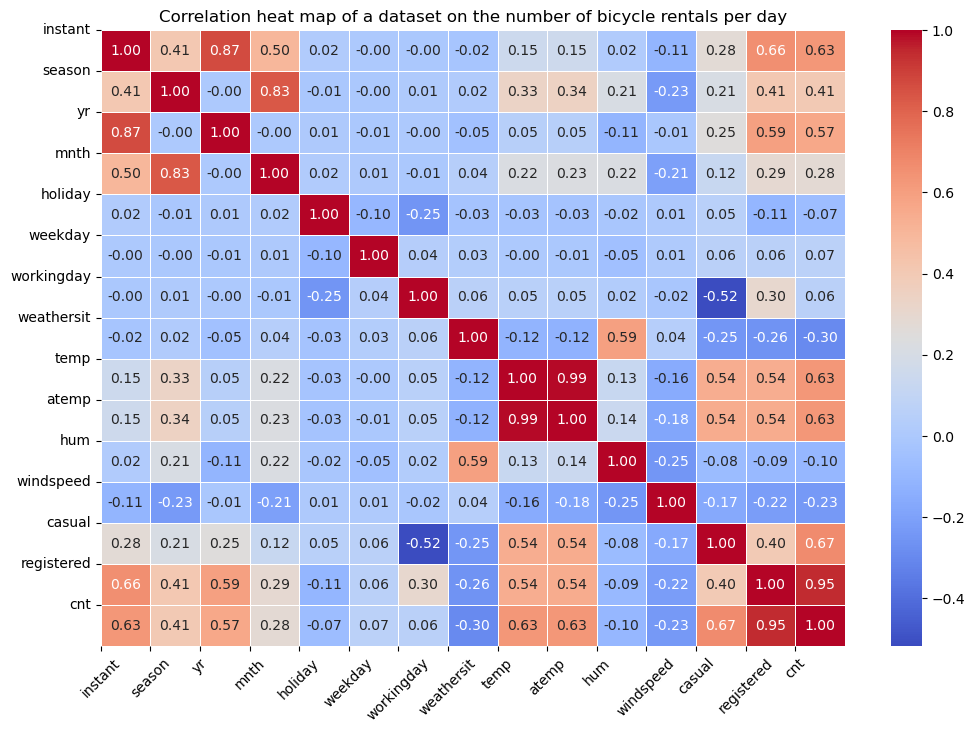

In [11]:
# Создание подмножества данных только с выбранными признаками
subset_data = data[selected_features]

# Рассчитываем корреляцию между признаками
correlation_matrix = subset_data.corr()

# Настройка параметров графика
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Добавление названий признаков на оси X и Y
plt.xticks(range(len(selected_features)), selected_features, rotation=45)
plt.yticks(range(len(selected_features)), selected_features, rotation=0)

# Отображение корреляционной тепловой карты
plt.title('Correlation heat map of a dataset on the number of bicycle rentals per day')
plt.show()

In [12]:
data.columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')

In [79]:
# Предобработка данных
data['dteday'] = pd.to_datetime(data['dteday'])
data['year'] = data['dteday'].dt.year
data['month'] = data['dteday'].dt.month
data['day'] = data['dteday'].dt.day
features = data.drop(['dteday','season'], axis=1)  #season - целевая переменная
target = data['season']

In [40]:
# Нормализация данных
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

In [41]:
# Разделение на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)

In [42]:
# Обучение различных моделей
# Линейная регрессия
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

LinearRegression()

In [43]:
# Полиномиальная регрессия
poly_model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
poly_model.fit(X_train, y_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

In [44]:
# Случайный лес
rf_model = RandomForestRegressor(random_state=42)
rf_grid = GridSearchCV(rf_model, param_grid={'n_estimators': [100, 200, 300], 'max_depth': [10, 20, 30]}, cv=5)
rf_grid.fit(X_train, y_train)
rf_model_best = rf_grid.best_estimator_

In [45]:
# SVR
svr_model = SVR()
svr_grid = GridSearchCV(svr_model, param_grid={'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']}, cv=5)
svr_grid.fit(X_train, y_train)
svr_model_best = svr_grid.best_estimator_

In [61]:
# Выводим важность признаков для случайного леса
feature_importances = rf_model_best.feature_importances_
print("Важность признаков:", feature_importances)

Важность признаков: [8.27568926e-02 2.12146036e-04 4.47080330e-01 0.00000000e+00
 9.83587343e-04 2.02675831e-04 6.55928809e-04 5.76194073e-03
 1.05492879e-02 4.29103586e-03 1.65904937e-03 3.46028621e-03
 1.56383554e-02 2.70097985e-02 5.11667821e-04 3.79176216e-01
 2.00508016e-02]


In [64]:
# Случайный лес
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30]
}
rf_model = RandomForestRegressor(random_state=42)
rf_grid = GridSearchCV(rf_model, param_grid=param_grid_rf, cv=5, scoring='neg_mean_squared_error')
rf_grid.fit(X_train, y_train)
rf_model_best = rf_grid.best_estimator_
print("Наилучшие параметры для случайного леса:", rf_grid.best_params_)

Наилучшие параметры для случайного леса: {'max_depth': 10, 'n_estimators': 100}


In [65]:
# Градиентный бустинг
param_grid_gb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1, 0.2]
}
gb_model = GradientBoostingRegressor(random_state=42)
gb_grid = GridSearchCV(gb_model, param_grid=param_grid_gb, cv=5, scoring='neg_mean_squared_error')
gb_grid.fit(X_train, y_train)
gb_model_best = gb_grid.best_estimator_
print("Наилучшие параметры для градиентного бустинга:", gb_grid.best_params_)


Наилучшие параметры для градиентного бустинга: {'learning_rate': 0.1, 'n_estimators': 200}


In [66]:
# SVM
param_grid_svm = {
    'C': [0.1, 1, 10],
    'epsilon': [0.1, 0.2, 0.5]
}
svm_model = SVR()
svm_grid = GridSearchCV(svm_model, param_grid=param_grid_svm, cv=5, scoring='neg_mean_squared_error')
svm_grid.fit(X_train, y_train)
svm_model_best = svm_grid.best_estimator_
print("Наилучшие параметры для SVM:", svm_grid.best_params_)


Наилучшие параметры для SVM: {'C': 1, 'epsilon': 0.2}


In [68]:
# Выбор лучшей модели и её сохранение
models = [linear_model, poly_model, rf_model_best, svm_model_best]
best_model = sorted([(model, mean_squared_error(y_test, model.predict(X_test))) for model in models], key=lambda x: x[1])[0][0]

with open('modelTop.pkl', 'wb') as file:
    pickle.dump(best_model, file)

Модель с наименьшей ошибкой на тестовых данных выбирается, как лучшая модель и сохраняется в файл 'modelTop.joblib'

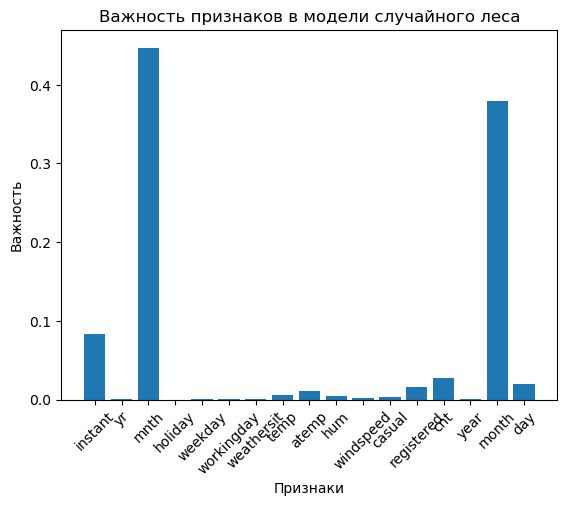

In [69]:
# График важности признаков для случайного леса
feature_importances = rf_model_best.feature_importances_
features_list = list(features.columns)
plt.bar(features_list, feature_importances)
plt.xlabel('Признаки')
plt.ylabel('Важность')
plt.title('Важность признаков в модели случайного леса')
plt.xticks(rotation=45)
plt.show()

Высокую важность составляет месяц, тот который был изначально и который мы извлекли из dteday

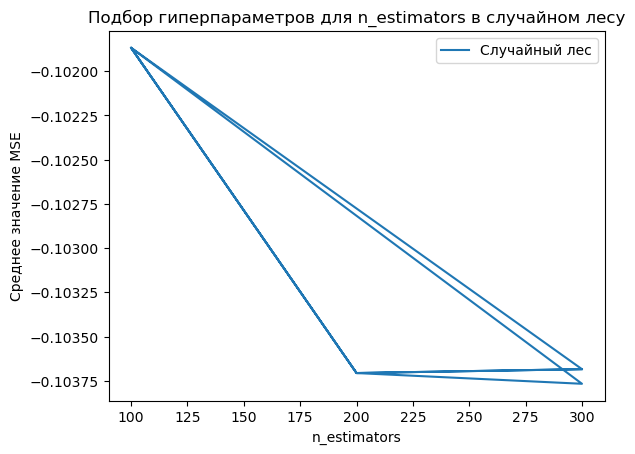

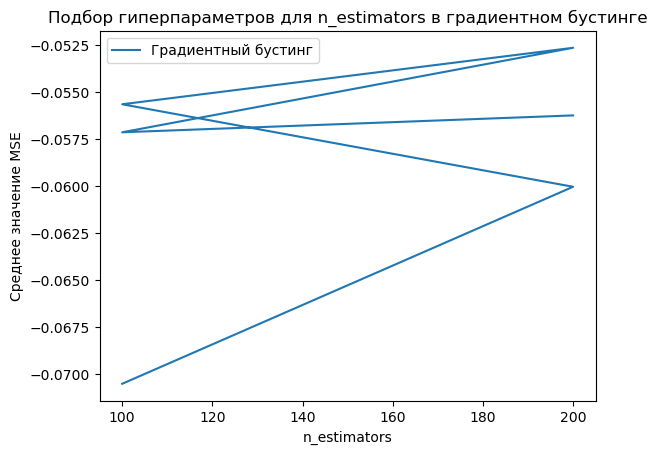

In [70]:
# Графики результатов подбора гиперпараметров
rf_results = pd.DataFrame(rf_grid.cv_results_)
plt.plot(rf_results['param_n_estimators'], rf_results['mean_test_score'], label='Случайный лес')
plt.xlabel('n_estimators')
plt.ylabel('Среднее значение MSE')
plt.title('Подбор гиперпараметров для n_estimators в случайном лесу')
plt.legend()
plt.show()

gb_results = pd.DataFrame(gb_grid.cv_results_)
plt.plot(gb_results['param_n_estimators'], gb_results['mean_test_score'], label='Градиентный бустинг')
plt.xlabel('n_estimators')
plt.ylabel('Среднее значение MSE')
plt.title('Подбор гиперпараметров для n_estimators в градиентном бустинге')
plt.legend()
plt.show()

Данные графики показывают, как модель реагирует на изменение значения гиперпараметров.
Скачущий график говорит о том, что изменение значения гиперпараметра "n_estimators" существенно влияет на производительность модели. Это указывает на неустойчивость модели при различных значениях данного гиперпараметра.

In [71]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
# Линейная регрессия
linear_r2 = linear_model.score(X_test, y_test)
linear_mse = mean_squared_error(y_test, linear_model.predict(X_test))
linear_mae = mean_absolute_error(y_test, linear_model.predict(X_test))
print("Линейная регрессия - R^2:", linear_r2, "MSE:", linear_mse, "MAE:", linear_mae)

Линейная регрессия - R^2: 0.6747963033995596 MSE: 0.42189645196430864 MAE: 0.42543895401820087


* Значение R^2 равное 0.675 указывает на то, что 67.5% дисперсии целевой переменной может быть объяснено используемой моделью
* Значение MSE равное 0.422 указывает на относительно низкий уровень среднеквадратичной ошибки,что означает хорошее качество модели в предсказании.
* Значение MAE равное 0.425 также представляет собой относительно небольшое среднее абсолютное отклонение между прогнозируемыми и фактическими значениями, что также является показателем хорошего качества модели.

In [72]:
# Полиномиальная регрессия
poly_r2 = poly_model.score(X_test, y_test)
poly_mse = mean_squared_error(y_test, poly_model.predict(X_test))
poly_mae = mean_absolute_error(y_test, poly_model.predict(X_test))
print("Полиномиальная регрессия - R^2:", poly_r2, "MSE:", poly_mse, "MAE:", poly_mae)

Полиномиальная регрессия - R^2: 0.7220868673224741 MSE: 0.36054499335840445 MAE: 0.3777353714923469


* Значение R^2, равное 0.722, указывает на то, что около 72.2% дисперсии целевой переменной может быть объяснено использованной полиномиальной регрессией.

* Значение MSE, равное 0.360, означает, что средняя квадратичная ошибка между прогнозируемыми значениями и фактическими значениями составляет примерно 0.360. Чем меньше это значение, тем лучше качество модели.

* Значение MAE, равное 0.378, указывает на то, что среднее абсолютное отклонение между прогнозируемыми значениями и фактическими значениями составляет примерно 0.378.

* Выводы: полиномиальная регрессия показывает лучшие результаты по сравнению с предыдущей моделью, так как значения R^2 ближе к 1, а MSE и MAE уменьшились, что свидетельствует о повышении точности предсказаний.

In [73]:
# Случайный лес
rf_r2 = rf_model_best.score(X_test, y_test)
rf_mse = mean_squared_error(y_test, rf_model_best.predict(X_test))
rf_mae = mean_absolute_error(y_test, rf_model_best.predict(X_test))
print("Случайный лес - R^2:", rf_r2, "MSE:", rf_mse, "MAE:", rf_mae)

Случайный лес - R^2: 0.8842253085538989 MSE: 0.15019795918367346 MAE: 0.13625850340136053


* Значение R^2, равное 0.884, указывает на то, что примерно 88.4% дисперсии целевой переменной может быть объяснено с использованием модели случайного леса.

* Значение MSE, равное 0.150, означает, что средняя квадратичная ошибка между прогнозируемыми значениями и фактическими значениями составляет примерно 0.150. Чем меньше это значение, тем лучше качество модели.

* Значение MAE, равное 0.136, указывает на то, что среднее абсолютное отклонение между прогнозируемыми значениями и фактическими значениями составляет примерно 0.136.

* Вывод: высокая точность модели случайного леса, поскольку значения R^2 близки к 1, а MSE и MAE имеют низкие значения, что свидетельствует о хорошей способности модели делать точные прогнозы. Также случайный лес показывает лучше результаты, чем два предыдущих

In [74]:
# SVR
svr_r2 = svr_model_best.score(X_test, y_test)
svr_mse = mean_squared_error(y_test, svr_model_best.predict(X_test))
svr_mae = mean_absolute_error(y_test, svr_model_best.predict(X_test))
print("SVR - R^2:", svr_r2, "MSE:", svr_mse, "MAE:", svr_mae)

SVR - R^2: 0.6958393697929484 MSE: 0.3945966545062005 MAE: 0.39121600034393833


* Значение R^2, равное 0.696, говорит о том, что примерно 69.6% дисперсии целевой переменной может быть объяснено с использованием модели SVR.

* Значение MSE, равное 0.395, указывает на среднеквадратичную ошибку, приблизительно равную 0.395. Чем меньше это значение, тем лучше для модели.

* Значение MAE, равное 0.391, указывает на среднее абсолютное отклонение, близкое к значению 0.391.

* Исходя из этих результатов, можно сделать вывод о том, что модель SVR представляет собой приемлемый вариант для предсказания, однако, значения R^2, MSE и MAE указывают на то, что модель может быть улучшена для достижения более высокой точности предсказаний.

In [75]:
# Создание массивов значений метрик для каждой модели
r2_values = [linear_r2, poly_r2, rf_r2, svr_r2]
mse_values = [linear_mse, poly_mse, rf_mse, svr_mse]
mae_values = [linear_mae, poly_mae, rf_mae, svr_mae]
models = ['Linear Regression', 'Polynomial Regression', 'Random Forest', 'SVR']

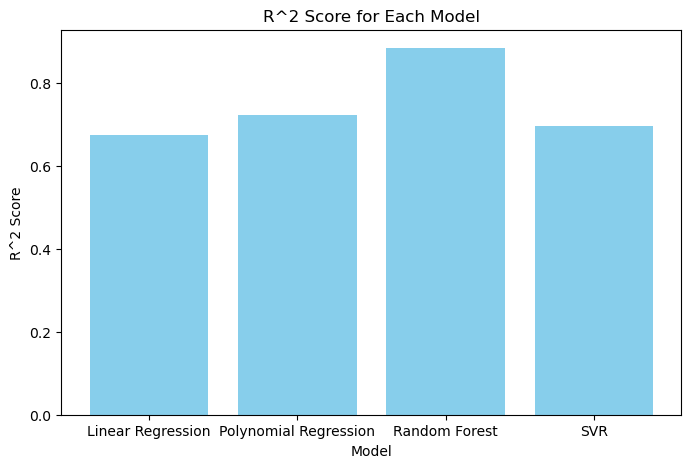

In [76]:
# Построение графика коэффициента детерминации
plt.figure(figsize=(8, 5))
plt.bar(models, r2_values, color='skyblue')
plt.title('R^2 Score for Each Model')
plt.xlabel('Model')
plt.ylabel('R^2 Score')
plt.show()

График демонстрирует коэффициент детерминации (R^2) для каждой модели. Из графика можно сделать вывод о том, какая модель показывает наилучшую производительность по сравнению с другими. Таким образом, можно сделать вывод, что Random Forest показывает  один из лучших результатов, затем идет Polynomial Regression, а SVR и Linear Regression находятся на одном уровне.

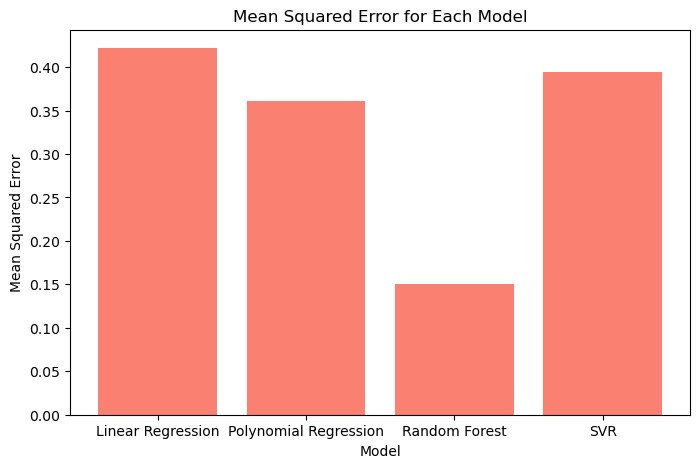

In [77]:
# Построение графика среднеквадратичной ошибки
plt.figure(figsize=(8, 5))
plt.bar(models, mse_values, color='salmon')
plt.title('Mean Squared Error for Each Model')
plt.xlabel('Model')
plt.ylabel('Mean Squared Error')
plt.show()

График отображает значения среднеквадратичной ошибки для каждой модели в виде столбчатой диаграммы. Это позволяет визуально сравнить производительность различных моделей по значению MSE.Лучшей моделью является Random Forest.

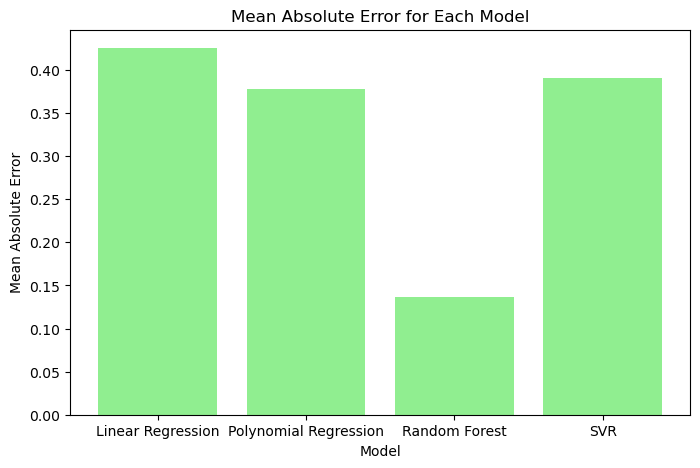

In [78]:
# Построение графика средней абсолютной ошибки
plt.figure(figsize=(8, 5))
plt.bar(models, mae_values, color='lightgreen')
plt.title('Mean Absolute Error for Each Model')
plt.xlabel('Model')
plt.ylabel('Mean Absolute Error')
plt.show()

График демонстрирует значения средней абсолютной ошибки для каждой модели, используя столбчатую диаграмму. Это позволяет визуально сравнить производительность различных моделей по значению MAE. Лучшей моделью является Random Forest.

### Вывод
Мы можем сделать вывод, что  наилучшим выбором среди представленных моделей для данного набора данных является модель случайного леса, за ней следует полиномиальная регрессия, затем - модель SVR, и, наконец, линейная регрессия.